# Gan para generar prendas de ropa y accesorios

Para este proyecto usaremos el dataset que tiene por defecto *keras* el cual es `fasion_mnist`.

El objetivo será crear un generador de imágenes de prendas de ropas y accesorios, para ello entrenaremos una *red generativa adversaria*, donde un generador y un discriminador se entrenarán mutuamente para afinar el rendimiento.

## Importación de librerías

In [43]:
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [44]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

## Carga y muestra de las imágenes del dataset

### Crear constantes del dataset y modelo

Declarando las siguientes constantes conseguiremos que para aumentar el rendimiento del modelo sea mucho más sencillo, solo tendremos que modificar estos valores.

In [45]:
IMG_SIZE = (28, 28)
BATCH_SIZE = 32
NUMBER_OF_FILES = 70000
EPOCHS = 100
LATENT_DIM = 100 # Semilla del generador

Importaremos a continuación el dataset y normalizaremos los datos preparandolo para nuestro posterior entrenamiento.

In [46]:
# Importamos el dataset
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Concatenamos los datos de entrenamiento y test en un solo array. 
# Los valores de y no nos interesan, por lo que no los concatenamos ni haremos nada con ellos
images = np.concatenate((X_train, X_test))

In [47]:
# Tendremos 70000 imagenes
print(images.shape)

(70000, 28, 28)


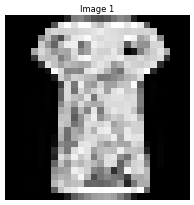

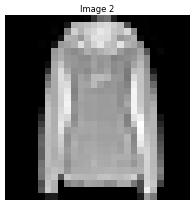

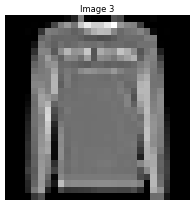

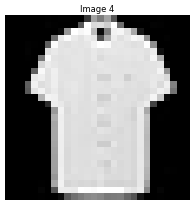

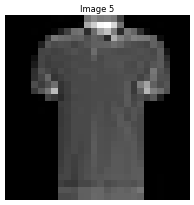

In [48]:
# Podemos mostrar algunas imagenes
sample_images = random.sample(list(images), 5)
count = 1
for image in sample_images:
    plt.figure(dpi=50)
    plt.title(f"Image {count}")
    plt.imshow(image, cmap="gray")
    plt.axis("off")
    count+=1
    plt.show()

Lo que haremos es capar el número de imágenes que usaremos para el modelo, posteriormente cambiando las constantes de arriba podremos probar con un lote mayor.

In [49]:
images = images[:NUMBER_OF_FILES]

Ahora un paso importante que debemos de hacer es normalizar entre $-1$ y $1$, que es lo ideal para nuestro modelo de generación e inicializar el dataset de tensorflow.

In [50]:
dataset_images = images / 127.5 - 1.0
dataset_images = tf.expand_dims(dataset_images, -1) # Añadimos una dimensión para el canal de color
dataset_images = tf.data.Dataset.from_tensor_slices(dataset_images).shuffle(NUMBER_OF_FILES).batch(BATCH_SIZE)
print(f"Dataset procesado: {NUMBER_OF_FILES} imágenes cargadas y preparadas.")

Dataset procesado: 70000 imágenes cargadas y preparadas.


Vamos a verificar las dimensiones del lote:

In [51]:
for batch in dataset_images.take(1):
    print("Dimensiones del lote:", batch.shape)
    print(f"Rango: ({batch.numpy().min()} a {batch.numpy().max()})")

Dimensiones del lote: (32, 28, 28, 1)
Rango: (-1.0 a 1.0)


## Creación de la **GAN**

### Creación del Generador

In [52]:
generator = keras.Sequential([
    layers.Input(shape=(LATENT_DIM,), name="gen_input_layer"),

    layers.Dense(7*7*128, name="gen_first_dense_layer"),
    layers.BatchNormalization(name="gen_first_bn_layer"),
    layers.LeakyReLU(name="gen_first_leakyrelu_layer"),

    layers.Reshape((7, 7, 128), name="gen_reshape_layer"),

    # Primera capa convolucional transpuesta: de 7x7 a 14x14
    layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same", activation="selu", name="gen_first_conv2d_layer"),
    layers.BatchNormalization(name="gen_second_bn_layer"),
    layers.LeakyReLU(name="gen_second_leakyrelu_layer"),

    # Segunda capa convolucional transpuesta, OUTPUT: de 14x14 a 28x28
    layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding="same", activation="tanh", name="gen_second_conv2d_layer"),
])

generator.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gen_first_dense_layer (Dense)   │ (None, 6272)           │       633,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gen_first_bn_layer              │ (None, 6272)           │        25,088 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gen_first_leakyrelu_layer       │ (None, 6272)           │             0 │
│ (LeakyReLU)                     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gen_reshape_layer (Reshape)     │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gen_first_conv2d_layer          │ (None, 14, 14, 64)     │       204,864 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gen_second_bn_layer             │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gen_second_leakyrelu_layer      │ (None, 14, 14, 64)     │             0 │
│ (LeakyReLU)                     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gen_second_conv2d_layer         │ (None, 28, 28, 1)      │         1,601 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 865,281 (3.30 MB)

 Trainable params: 852,609 (3.25 MB)

 Non-trainable params: 12,672 (49.50 KB)

#### Probaremos el generador antes del entrenamiento

Primero de todos deberemos de crear ruido, que será lo que introduzcamos como entrada para generar las imágenes.

In [53]:
noise = tf.random.normal([1, LATENT_DIM])

Dimensiones de la imagen generada: (1, 28, 28, 1)
Rango de valores de la imagen generada: -0.13992767 - 0.109745845


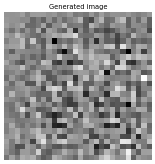

In [54]:
generated_image = generator(noise, training=False)
print("Dimensiones de la imagen generada:", generated_image.shape)
print("Rango de valores de la imagen generada:", generated_image.numpy().min(), "-", generated_image.numpy().max())
plt.figure(dpi=40)
plt.imshow((generated_image[0] + 1) / 2, cmap="grey") # Reescala la imagen al rango [0, 1] para visualizarla 
plt.axis("off")
plt.title("Generated image")
plt.show()

### Creación del Descriminador

In [55]:
discriminator = keras.Sequential([
    layers.Input(shape=(28, 28, 1), name="dis_input_layer"),

    # Primera capa convolucional
    layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same", name="dis_first_conv2d_layer"),
    layers.LeakyReLU(name="dis_first_leakyrelu_layer"),
    layers.Dropout(0.3, name="dis_first_dropout_layer"),

    # Segunda capa convolucional
    layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same", name="dis_second_conv2d_layer"),
    layers.LeakyReLU(name="dis_second_leakyrelu_layer"),
    layers.Dropout(0.3, name="dis_second_dropout_layer"),

    layers.Flatten(name="dis_flatten_layer"),
    layers.Dense(1, activation="sigmoid", name="dis_output_layer"),
])

discriminator.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dis_first_conv2d_layer (Conv2D) │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dis_first_leakyrelu_layer       │ (None, 14, 14, 64)     │             0 │
│ (LeakyReLU)                     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dis_first_dropout_layer         │ (None, 14, 14, 64)     │             0 │
│ (Dropout)                       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dis_second_conv2d_layer         │ (None, 7, 7, 128)      │       204,928 │
│ (Conv2D)                        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dis_second_leakyrelu_layer      │ (None, 7, 7, 128)      │             0 │
│ (LeakyReLU)                     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dis_second_dropout_layer        │ (None, 7, 7, 128)      │             0 │
│ (Dropout)                       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dis_flatten_layer (Flatten)     │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dis_output_layer (Dense)        │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

#### Comprobación del discriminador

In [56]:
decision = discriminator(generated_image)
print("Decision:", decision.numpy())

Decision: [[0.49971545]]


### Inicializar optimizadores y función de pérdida

In [57]:
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=False)
generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

### Entrenamiento de la GAN y carga de modelos

In [58]:
# Cargar el modelo desde local si existe, con la mayor epoca:

def load_latest_models(model_dir="models"):
    """Carga el ultimo modelo guardado si existe"""
    try:
        if not os.path.exists(model_dir):
            print(f"El directorio {model_dir} no existe.")
            return None, None, 0
         
        generator_files = [f for f in os.listdir(model_dir) if f.startswith("generador_fashion_")]
        if not generator_files:
            return None, None, 0
        
        # Parsear y extraer (época, imágenes) de los nombres
        file_info = []
        for file in generator_files:
            # Formato: generador_fashion_{epoch}ep_{imgCount}img.keras
            parts = file.split("_")  
            epoch_str = parts[2].replace("ep", "")
            img_str = parts[3].replace("img.keras", "")
            epoch = int(epoch_str)
            img_count = int(img_str)
            file_info.append((epoch, img_count, file))

        # Ordenar: primero por número de imágenes, luego por época, ambos descendentes
        file_info.sort(key=lambda x: (x[1], x[0]), reverse=True)
        best_epoch, highest_img_count, _ = file_info[0]

        # Cargar modelo
        generator = tf.keras.models.load_model(
            f"models/generador_fashion_{best_epoch}ep_{highest_img_count}img.keras"
        )
        discriminator = tf.keras.models.load_model(
            f"models/discriminador_fashion_{best_epoch}ep_{highest_img_count}img.keras"
        )

        return generator, discriminator, best_epoch
    except Exception as e:
        print(f"Error loading models: {str(e)}")
        return None, None, 0

In [59]:
def train_gan(resume_epoch=0, epochs=EPOCHS):
    for epoch in tqdm(range(resume_epoch, epochs)):
        print(f"Época {epoch + 1}/{EPOCHS}...") 

        for real_images in dataset_images: 
            current_batch_size = real_images.shape[0]

            noise = tf.random.normal([current_batch_size, LATENT_DIM])

            generated_images = generator(noise, training=True)

            real_labels = tf.ones((current_batch_size, 1)) 
            false_labels = tf.zeros((current_batch_size, 1)) 

            with tf.GradientTape() as disc_tape: 
                real_output = discriminator(real_images, training=True)
                fake_output = discriminator(generated_images, training=True)
                disc_loss_real = cross_entropy(real_labels, real_output)
                disc_loss_fake = cross_entropy(false_labels, fake_output)
                disc_loss = disc_loss_real + disc_loss_fake

            gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
            discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

            noise = tf.random.normal([current_batch_size, LATENT_DIM])

            with tf.GradientTape() as gen_tape: 
                generated_images = generator(noise, training=True)
                fake_output = discriminator(generated_images, training=False)
                gen_loss = cross_entropy(real_labels, fake_output)

            gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
            generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

        print(f"Pérdida del discriminador: {disc_loss.numpy()}, Pérdida del generador: {gen_loss.numpy()}")

        if (epoch + 1) % 10 == 0 or epoch == EPOCHS - 1:
            noise = tf.random.normal([16, LATENT_DIM])
            generated_images = generator(noise, training=False)
            generated_images = (generated_images + 1) / 2 


            fig, axes = plt.subplots(4, 4, figsize=(6, 6))
            for img, ax in zip(generated_images, axes.flatten()):
                ax.imshow(img, cmap="gray")
                ax.axis("off")
            plt.show()

            os.makedirs("models", exist_ok=True)
            generator.save(f"models/generador_fashion_{epoch+1}ep_{NUMBER_OF_FILES}img.keras")
            discriminator.save(f"models/discriminador_fashion_{epoch+1}ep_{NUMBER_OF_FILES}img.keras")

Modelos cargados de la época 10. Continuando con el entrenamiento...


  0%|          | 0/90 [00:00<?, ?it/s]

Época 11/100...


  1%|          | 1/90 [06:48<10:06:18, 408.74s/it]

Pérdida del discriminador: 1.3879780769348145, Pérdida del generador: 0.7276866436004639
Época 12/100...


  2%|▏         | 2/90 [13:26<9:50:25, 402.57s/it] 

Pérdida del discriminador: 1.4762213230133057, Pérdida del generador: 0.5842757225036621
Época 13/100...


  3%|▎         | 3/90 [20:10<9:44:10, 402.89s/it]

Pérdida del discriminador: 1.2971714735031128, Pérdida del generador: 0.8018059730529785
Época 14/100...


  4%|▍         | 4/90 [26:32<9:25:51, 394.79s/it]

Pérdida del discriminador: 1.4743437767028809, Pérdida del generador: 0.8406075239181519
Época 15/100...


  6%|▌         | 5/90 [32:49<9:10:03, 388.28s/it]

Pérdida del discriminador: 1.3150081634521484, Pérdida del generador: 0.8549705147743225
Época 16/100...


  7%|▋         | 6/90 [39:06<8:58:11, 384.42s/it]

Pérdida del discriminador: 1.4029242992401123, Pérdida del generador: 0.6987020373344421
Época 17/100...


  8%|▊         | 7/90 [45:24<8:48:59, 382.40s/it]

Pérdida del discriminador: 1.245708703994751, Pérdida del generador: 0.7366579174995422
Época 18/100...


  9%|▉         | 8/90 [51:41<8:40:03, 380.53s/it]

Pérdida del discriminador: 1.3899571895599365, Pérdida del generador: 0.8515475988388062
Época 19/100...


 10%|█         | 9/90 [57:58<8:32:23, 379.55s/it]

Pérdida del discriminador: 1.3967111110687256, Pérdida del generador: 0.8703122138977051
Época 20/100...
Pérdida del discriminador: 1.26198148727417, Pérdida del generador: 0.6373929977416992


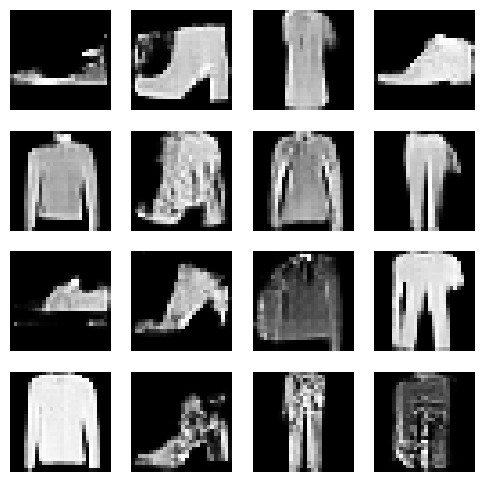

 11%|█         | 10/90 [1:04:17<8:25:48, 379.36s/it]

Época 21/100...


 12%|█▏        | 11/90 [1:10:35<8:19:00, 379.00s/it]

Pérdida del discriminador: 1.539388656616211, Pérdida del generador: 0.6711958646774292
Época 22/100...


 13%|█▎        | 12/90 [1:16:52<8:11:41, 378.23s/it]

Pérdida del discriminador: 1.4782302379608154, Pérdida del generador: 0.7621029615402222
Época 23/100...


 14%|█▍        | 13/90 [1:23:08<8:04:31, 377.55s/it]

Pérdida del discriminador: 1.313167691230774, Pérdida del generador: 0.730014443397522
Época 24/100...


 16%|█▌        | 14/90 [1:29:24<7:57:40, 377.12s/it]

Pérdida del discriminador: 1.2945339679718018, Pérdida del generador: 0.7822345495223999
Época 25/100...


 17%|█▋        | 15/90 [1:35:40<7:51:09, 376.92s/it]

Pérdida del discriminador: 1.318597674369812, Pérdida del generador: 0.8048033118247986
Época 26/100...


 18%|█▊        | 16/90 [1:41:56<7:44:29, 376.61s/it]

Pérdida del discriminador: 1.3404136896133423, Pérdida del generador: 0.7693513631820679
Época 27/100...


 19%|█▉        | 17/90 [1:48:13<7:38:11, 376.60s/it]

Pérdida del discriminador: 1.3394149541854858, Pérdida del generador: 0.8447569012641907
Época 28/100...


 20%|██        | 18/90 [1:54:29<7:31:42, 376.42s/it]

Pérdida del discriminador: 1.257817268371582, Pérdida del generador: 0.8302475214004517
Época 29/100...


 21%|██        | 19/90 [2:00:45<7:25:23, 376.38s/it]

Pérdida del discriminador: 1.3664957284927368, Pérdida del generador: 0.7289159893989563
Época 30/100...
Pérdida del discriminador: 1.353531837463379, Pérdida del generador: 0.7780095934867859


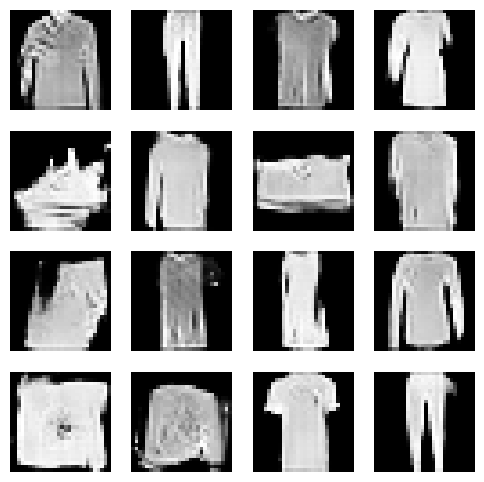

 22%|██▏       | 20/90 [2:07:01<7:19:00, 376.30s/it]

Época 31/100...


 23%|██▎       | 21/90 [2:13:18<7:13:00, 376.53s/it]

Pérdida del discriminador: 1.2807061672210693, Pérdida del generador: 0.667530357837677
Época 32/100...


 24%|██▍       | 22/90 [2:19:35<7:06:48, 376.59s/it]

Pérdida del discriminador: 1.2342960834503174, Pérdida del generador: 0.8488866686820984
Época 33/100...


 26%|██▌       | 23/90 [2:25:52<7:00:47, 376.83s/it]

Pérdida del discriminador: 1.5463589429855347, Pérdida del generador: 0.7531502842903137
Época 34/100...


 27%|██▋       | 24/90 [2:32:10<6:54:42, 377.00s/it]

Pérdida del discriminador: 1.2695564031600952, Pérdida del generador: 0.8603500723838806
Época 35/100...


 28%|██▊       | 25/90 [2:38:27<6:48:28, 377.05s/it]

Pérdida del discriminador: 1.3125088214874268, Pérdida del generador: 0.7824651002883911
Época 36/100...


 29%|██▉       | 26/90 [2:44:43<6:41:58, 376.85s/it]

Pérdida del discriminador: 1.3953208923339844, Pérdida del generador: 0.7221371531486511
Época 37/100...


 30%|███       | 27/90 [2:51:02<6:36:20, 377.47s/it]

Pérdida del discriminador: 1.409010410308838, Pérdida del generador: 0.7623387575149536
Época 38/100...


 31%|███       | 28/90 [2:57:18<6:29:44, 377.16s/it]

Pérdida del discriminador: 1.4333395957946777, Pérdida del generador: 0.713398814201355
Época 39/100...


 32%|███▏      | 29/90 [3:03:36<6:23:26, 377.16s/it]

Pérdida del discriminador: 1.2755513191223145, Pérdida del generador: 0.8495194911956787
Época 40/100...
Pérdida del discriminador: 1.3466591835021973, Pérdida del generador: 0.745237410068512


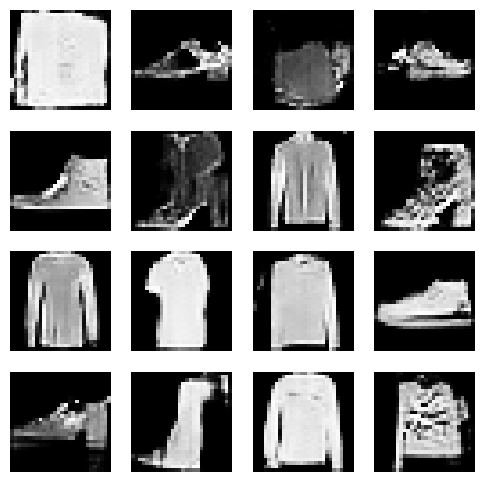

 33%|███▎      | 30/90 [3:09:57<6:18:23, 378.39s/it]

Época 41/100...


 34%|███▍      | 31/90 [3:16:14<6:11:46, 378.07s/it]

Pérdida del discriminador: 1.3479888439178467, Pérdida del generador: 0.8189427256584167
Época 42/100...


 36%|███▌      | 32/90 [3:22:49<6:10:21, 383.13s/it]

Pérdida del discriminador: 1.3836207389831543, Pérdida del generador: 0.6559814810752869
Época 43/100...


 37%|███▋      | 33/90 [3:29:09<6:02:55, 382.03s/it]

Pérdida del discriminador: 1.4284698963165283, Pérdida del generador: 0.7281931638717651
Época 44/100...


 38%|███▊      | 34/90 [3:35:26<5:55:10, 380.55s/it]

Pérdida del discriminador: 1.2691490650177002, Pérdida del generador: 0.758088231086731
Época 45/100...


 39%|███▉      | 35/90 [3:41:43<5:47:51, 379.48s/it]

Pérdida del discriminador: 1.4150639772415161, Pérdida del generador: 0.755688488483429
Época 46/100...


 40%|████      | 36/90 [3:47:59<5:40:47, 378.65s/it]

Pérdida del discriminador: 1.3748419284820557, Pérdida del generador: 0.8434884548187256
Época 47/100...


 41%|████      | 37/90 [3:54:16<5:34:01, 378.14s/it]

Pérdida del discriminador: 1.3912299871444702, Pérdida del generador: 0.7910576462745667
Época 48/100...


 42%|████▏     | 38/90 [4:00:33<5:27:18, 377.65s/it]

Pérdida del discriminador: 1.4052339792251587, Pérdida del generador: 0.7503476142883301
Época 49/100...


 43%|████▎     | 39/90 [4:06:50<5:20:58, 377.62s/it]

Pérdida del discriminador: 1.373308539390564, Pérdida del generador: 0.6928415298461914
Época 50/100...
Pérdida del discriminador: 1.3700141906738281, Pérdida del generador: 0.7209862470626831


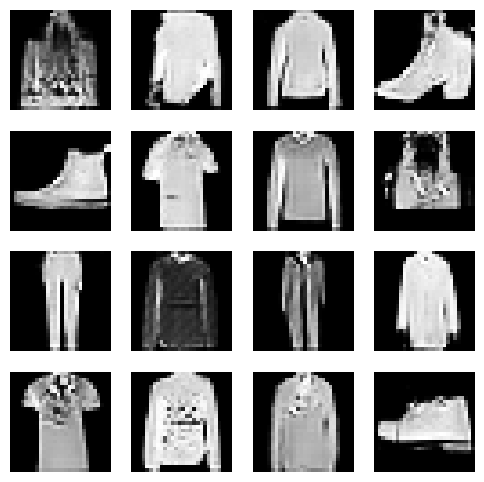

 44%|████▍     | 40/90 [4:13:07<5:14:30, 377.40s/it]

Época 51/100...


 46%|████▌     | 41/90 [4:19:26<5:08:34, 377.85s/it]

Pérdida del discriminador: 1.3679327964782715, Pérdida del generador: 0.7533184289932251
Época 52/100...


 47%|████▋     | 42/90 [4:26:08<5:07:59, 384.99s/it]

Pérdida del discriminador: 1.3592644929885864, Pérdida del generador: 0.8155990839004517
Época 53/100...


 48%|████▊     | 43/90 [4:32:44<5:04:08, 388.27s/it]

Pérdida del discriminador: 1.282076358795166, Pérdida del generador: 0.7073087096214294
Época 54/100...


 49%|████▉     | 44/90 [4:39:12<4:57:41, 388.30s/it]

Pérdida del discriminador: 1.4251811504364014, Pérdida del generador: 0.73138427734375
Época 55/100...


 50%|█████     | 45/90 [4:45:31<4:49:10, 385.56s/it]

Pérdida del discriminador: 1.3472384214401245, Pérdida del generador: 0.848749041557312
Época 56/100...


 51%|█████     | 46/90 [4:51:49<4:40:59, 383.16s/it]

Pérdida del discriminador: 1.4241610765457153, Pérdida del generador: 0.7380462884902954
Época 57/100...


 52%|█████▏    | 47/90 [4:58:06<4:33:18, 381.36s/it]

Pérdida del discriminador: 1.3396520614624023, Pérdida del generador: 0.7892686128616333
Época 58/100...


 53%|█████▎    | 48/90 [5:04:24<4:26:09, 380.22s/it]

Pérdida del discriminador: 1.3034011125564575, Pérdida del generador: 0.6718086004257202
Época 59/100...


 54%|█████▍    | 49/90 [5:10:34<4:17:43, 377.15s/it]

Pérdida del discriminador: 1.31510329246521, Pérdida del generador: 0.752751350402832
Época 60/100...
Pérdida del discriminador: 1.4047245979309082, Pérdida del generador: 0.6776173114776611


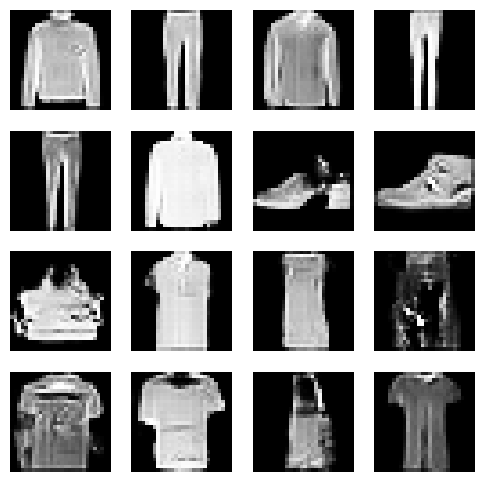

 56%|█████▌    | 50/90 [5:16:44<4:10:00, 375.02s/it]

Época 61/100...


 57%|█████▋    | 51/90 [5:22:54<4:02:55, 373.74s/it]

Pérdida del discriminador: 1.3400194644927979, Pérdida del generador: 0.7399857044219971
Época 62/100...


 58%|█████▊    | 52/90 [5:29:04<3:56:00, 372.65s/it]

Pérdida del discriminador: 1.4427895545959473, Pérdida del generador: 0.8492900133132935
Época 63/100...


 59%|█████▉    | 53/90 [5:35:15<3:49:22, 371.96s/it]

Pérdida del discriminador: 1.3696976900100708, Pérdida del generador: 0.720717191696167
Época 64/100...


 60%|██████    | 54/90 [5:41:25<3:42:52, 371.47s/it]

Pérdida del discriminador: 1.345069408416748, Pérdida del generador: 0.6568057537078857
Época 65/100...


 61%|██████    | 55/90 [5:47:36<3:36:37, 371.35s/it]

Pérdida del discriminador: 1.3832324743270874, Pérdida del generador: 0.7498779296875
Época 66/100...


 62%|██████▏   | 56/90 [5:53:47<3:30:19, 371.17s/it]

Pérdida del discriminador: 1.3887529373168945, Pérdida del generador: 0.7799344062805176
Época 67/100...


 63%|██████▎   | 57/90 [5:59:57<3:23:59, 370.89s/it]

Pérdida del discriminador: 1.3137601613998413, Pérdida del generador: 0.6839494705200195
Época 68/100...


 64%|██████▍   | 58/90 [6:06:08<3:17:45, 370.79s/it]

Pérdida del discriminador: 1.2266753911972046, Pérdida del generador: 0.8046837449073792
Época 69/100...


 66%|██████▌   | 59/90 [6:12:18<3:11:30, 370.65s/it]

Pérdida del discriminador: 1.468085527420044, Pérdida del generador: 0.794123649597168
Época 70/100...
Pérdida del discriminador: 1.3093202114105225, Pérdida del generador: 0.7866438031196594


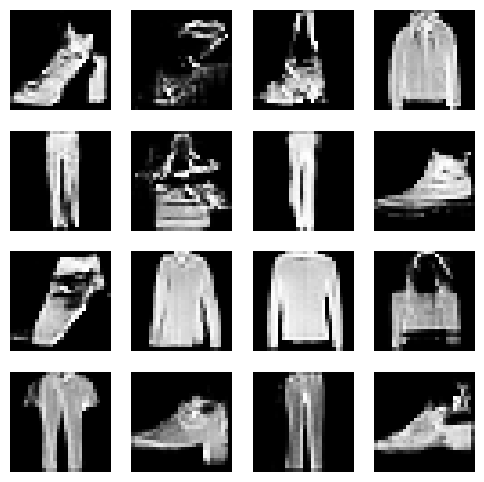

 67%|██████▋   | 60/90 [6:18:30<3:05:26, 370.88s/it]

Época 71/100...


 68%|██████▊   | 61/90 [6:24:39<2:59:06, 370.57s/it]

Pérdida del discriminador: 1.29796302318573, Pérdida del generador: 0.8196207880973816
Época 72/100...


 69%|██████▉   | 62/90 [6:30:50<2:52:56, 370.60s/it]

Pérdida del discriminador: 1.3467732667922974, Pérdida del generador: 0.8115592002868652
Época 73/100...


 70%|███████   | 63/90 [6:36:59<2:46:36, 370.24s/it]

Pérdida del discriminador: 1.3881840705871582, Pérdida del generador: 0.7532082796096802
Época 74/100...


 71%|███████   | 64/90 [6:43:11<2:40:33, 370.50s/it]

Pérdida del discriminador: 1.4231641292572021, Pérdida del generador: 0.7466721534729004
Época 75/100...


 72%|███████▏  | 65/90 [6:49:22<2:34:27, 370.70s/it]

Pérdida del discriminador: 1.3544381856918335, Pérdida del generador: 0.7510924339294434
Época 76/100...


 73%|███████▎  | 66/90 [6:55:32<2:28:12, 370.51s/it]

Pérdida del discriminador: 1.3139455318450928, Pérdida del generador: 0.7677485346794128
Época 77/100...


 74%|███████▍  | 67/90 [7:01:42<2:22:02, 370.53s/it]

Pérdida del discriminador: 1.3282504081726074, Pérdida del generador: 0.7422254085540771
Época 78/100...


 76%|███████▌  | 68/90 [7:07:52<2:15:46, 370.29s/it]

Pérdida del discriminador: 1.4501228332519531, Pérdida del generador: 0.7161966562271118
Época 79/100...


 77%|███████▋  | 69/90 [7:14:03<2:09:37, 370.35s/it]

Pérdida del discriminador: 1.2834458351135254, Pérdida del generador: 0.7466192245483398
Época 80/100...
Pérdida del discriminador: 1.3234673738479614, Pérdida del generador: 0.7414305806159973


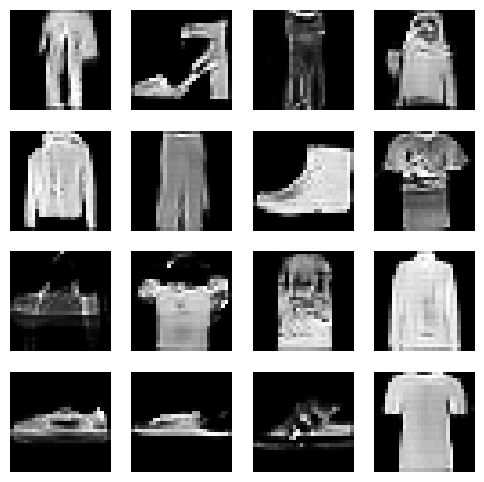

 78%|███████▊  | 70/90 [7:20:13<2:03:30, 370.52s/it]

Época 81/100...


 79%|███████▉  | 71/90 [7:26:25<1:57:23, 370.70s/it]

Pérdida del discriminador: 1.4910509586334229, Pérdida del generador: 0.750184178352356
Época 82/100...


 80%|████████  | 72/90 [7:32:35<1:51:12, 370.71s/it]

Pérdida del discriminador: 1.374861478805542, Pérdida del generador: 0.7290892004966736
Época 83/100...


 81%|████████  | 73/90 [7:38:47<1:45:05, 370.91s/it]

Pérdida del discriminador: 1.322887659072876, Pérdida del generador: 0.7947582006454468
Época 84/100...


 82%|████████▏ | 74/90 [7:44:58<1:38:55, 370.98s/it]

Pérdida del discriminador: 1.4855574369430542, Pérdida del generador: 0.7346645593643188
Época 85/100...


 83%|████████▎ | 75/90 [7:51:09<1:32:43, 370.92s/it]

Pérdida del discriminador: 1.3020166158676147, Pérdida del generador: 0.7138450145721436
Época 86/100...


 84%|████████▍ | 76/90 [7:57:19<1:26:31, 370.83s/it]

Pérdida del discriminador: 1.3747320175170898, Pérdida del generador: 0.8128745555877686
Época 87/100...


 86%|████████▌ | 77/90 [8:03:29<1:20:17, 370.61s/it]

Pérdida del discriminador: 1.4563894271850586, Pérdida del generador: 0.7585834264755249
Época 88/100...


 87%|████████▋ | 78/90 [8:09:40<1:14:07, 370.62s/it]

Pérdida del discriminador: 1.4823050498962402, Pérdida del generador: 0.7304085493087769
Época 89/100...


 88%|████████▊ | 79/90 [8:15:50<1:07:56, 370.55s/it]

Pérdida del discriminador: 1.4483507871627808, Pérdida del generador: 0.8113365769386292
Época 90/100...
Pérdida del discriminador: 1.334001064300537, Pérdida del generador: 0.8513790369033813


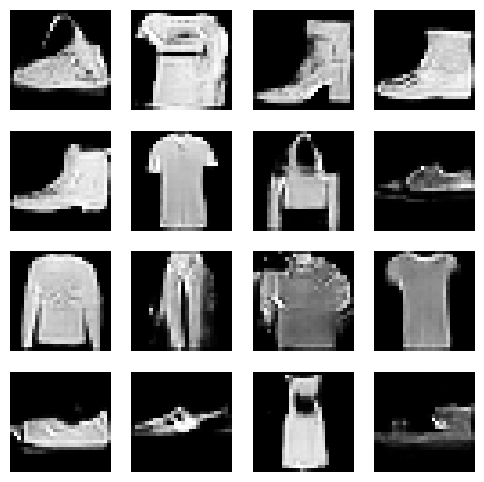

 89%|████████▉ | 80/90 [8:22:04<1:01:56, 371.60s/it]

Época 91/100...


 90%|█████████ | 81/90 [8:28:17<55:46, 371.81s/it]  

Pérdida del discriminador: 1.342941403388977, Pérdida del generador: 0.7200057506561279
Época 92/100...


 91%|█████████ | 82/90 [8:34:28<49:32, 371.62s/it]

Pérdida del discriminador: 1.316634178161621, Pérdida del generador: 0.7679628729820251
Época 93/100...


 92%|█████████▏| 83/90 [8:40:38<43:19, 371.29s/it]

Pérdida del discriminador: 1.3109971284866333, Pérdida del generador: 0.7766548991203308
Época 94/100...


 93%|█████████▎| 84/90 [8:46:51<37:09, 371.56s/it]

Pérdida del discriminador: 1.3209422826766968, Pérdida del generador: 0.708776593208313
Época 95/100...


 94%|█████████▍| 85/90 [8:53:01<30:55, 371.09s/it]

Pérdida del discriminador: 1.351370096206665, Pérdida del generador: 0.7544301748275757
Época 96/100...


 96%|█████████▌| 86/90 [8:59:12<24:44, 371.18s/it]

Pérdida del discriminador: 1.3682284355163574, Pérdida del generador: 0.7441117763519287
Época 97/100...


 97%|█████████▋| 87/90 [9:05:23<18:33, 371.08s/it]

Pérdida del discriminador: 1.3525689840316772, Pérdida del generador: 0.7078734636306763
Época 98/100...


 98%|█████████▊| 88/90 [9:11:33<12:21, 370.79s/it]

Pérdida del discriminador: 1.3779468536376953, Pérdida del generador: 0.7315622568130493
Época 99/100...


 99%|█████████▉| 89/90 [9:17:44<06:10, 370.81s/it]

Pérdida del discriminador: 1.3671002388000488, Pérdida del generador: 0.7612318396568298
Época 100/100...
Pérdida del discriminador: 1.2934499979019165, Pérdida del generador: 0.8781697750091553


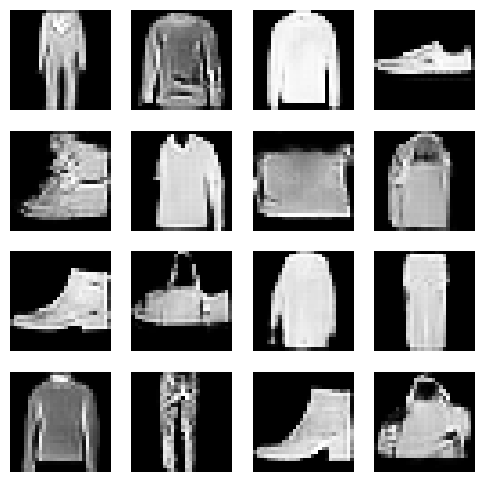

100%|██████████| 90/90 [9:23:54<00:00, 375.94s/it]


In [60]:
# Entrenamiento de la GAN
generator_loaded, discriminator_loaded, highest_epoch = load_latest_models("models")

if generator_loaded is not None and discriminator_loaded is not None and highest_epoch >= EPOCHS:
    print(f"Modelos cargados de la época {highest_epoch}. Tareas completas.")
elif generator_loaded is not None and discriminator_loaded is not None:
    print(f"Modelos cargados de la época {highest_epoch}. Continuando con el entrenamiento...")
    # Hacer un entrenamiento desde la epoca que estuviera hasta la epoca deseada
    generator = generator_loaded
    discriminator = discriminator_loaded
    train_gan(resume_epoch=highest_epoch, epochs=EPOCHS)
else:
    print(f"No se han encontrado modelos de forma local, continuaremos con un modelo desde cero...")
    # Hacer el entrenamiento desde cero
    train_gan(resume_epoch=0, epochs=EPOCHS)

#### Probar el generador cargado

Dimensiones de la imagen generada: (1, 28, 28, 1)
Rango de valores de la imagen generada: -1.0 - 0.84532636


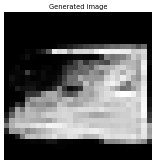

In [61]:
noise = tf.random.normal([1, LATENT_DIM])
generated_image = generator(noise, training=False)

print("Dimensiones de la imagen generada:", generated_image.shape)
print("Rango de valores de la imagen generada:", generated_image.numpy().min(), "-", generated_image.numpy().max())

plt.figure(dpi=40)
plt.imshow((generated_image[0] + 1) / 2, cmap="gray") 
plt.axis("off")
plt.title("Generated image")
plt.show()

Por último, generaremos 100 imágenes de muestra para tener una aproximación de qué tan optimizado es nuestro modelo.

In [62]:
number_of_sample_images = 100

for i in range(number_of_sample_images):
    generated_image = generator(noise, training=False)
    generated_image = (generated_image + 1) / 2
    plt.figure(dpi=50)
    os.makedirs("samples_generated", exist_ok=True)
    plt.imsave(fname=f"samples_generated/image_{i}.png", arr=generated_image[0], cmap="gray")

C:\Users\Hugo Peralta\AppData\Local\Temp\ipykernel_5716\3166636760.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(dpi=50)


<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>